In [276]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, norm, probplot, boxcox, f_oneway
from sklearn.preprocessing import LabelEncoder
import statsmodels
from sklearn.preprocessing import StandardScaler
import time
from sklearn.metrics import f1_score, make_scorer

In [125]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("winequalityN.csv")
df.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0       0.45      8.8        6  
1       0.49      9.5        6  
2       0.44     10.1        6  
3       0.40      9.9        6  
4       0.40      9.9        6

In [3]:
df.shape

(6497, 13)

In [4]:
df.quality.value_counts()

quality
6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: count, dtype: int64

In [5]:
df['quality_label'] = df.quality.apply(lambda q: 'low' if q <= 5 else 'medium' if q <= 7 else 'high')

In [6]:
df.quality_label.value_counts()

quality_label
medium    3915
low       2384
high       198
Name: count, dtype: int64

# Null Values

In [7]:
df.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
quality_label            0
dtype: int64

### Since the null records are very less -> we can remove null records

In [8]:
df.dropna(inplace=True)

# Comparing Red vs White Wine

<Axes: xlabel='quality', ylabel='Count'>

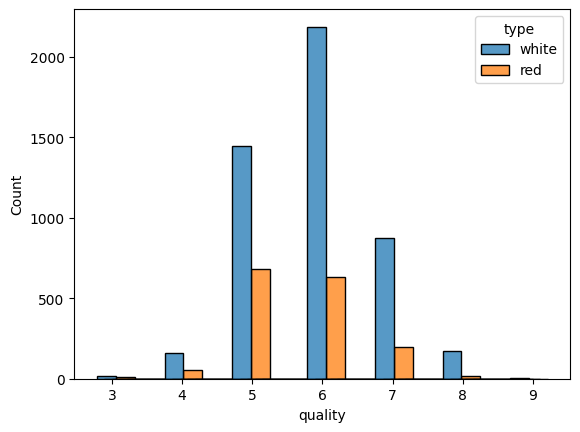

In [9]:
#sns.histplot(df.quality[df.type == 'red'].value_counts(), color='b')

sns.histplot(data = df,x='quality', hue='type', multiple="dodge", shrink=5)

In [10]:
#Comparing first 6 stats


def return_subset(df, x, start_col, end_col):
    cols = list(df.columns[start:end])
    return round(df.loc[df.type==x, cols].describe(),2)

In [11]:
start = 0
end = 6

pd.concat([return_subset(df, 'white', start, end), return_subset(df, 'red', start, end)], axis=1)

fixed acidity  volatile acidity  citric acid  residual sugar  \
count        4870.00           4870.00      4870.00         4870.00   
mean            6.86              0.28         0.33            6.39   
std             0.84              0.10         0.12            5.07   
min             3.80              0.08         0.00            0.60   
25%             6.30              0.21         0.27            1.70   
50%             6.80              0.26         0.32            5.20   
75%             7.30              0.32         0.39            9.90   
max            14.20              1.10         1.66           65.80   

       chlorides  fixed acidity  volatile acidity  citric acid  \
count    4870.00        1593.00           1593.00      1593.00   
mean        0.05           8.33              0.53         0.27   
std         0.02           1.74              0.18         0.19   
min         0.01           4.60              0.12         0.00   
25%         0.04           7.10              0.39         0.09   
50%         0.04           7.90              0.52         0.26   
75%         0.05           9.20              0.64         0.42   
max         0.35          15.90              1.58         1.00   

       residual sugar  chlorides  
count         1593.00    1593.00  
mean             2.54       0.09  
std              1.41       0.05  
min              0.90       0.01  
25%              1.90       0.07  
50%              2.20       0.08  
75%              2.60       0.09  
max             15.50       0.61

In [12]:
start = 6
end = 12

pd.concat([return_subset(df, 'white', start, end), return_subset(df, 'red', start, end)], axis=1)

free sulfur dioxide  total sulfur dioxide  density       pH  sulphates  \
count              4870.00               4870.00  4870.00  4870.00    4870.00   
mean                 35.32                138.34     0.99     3.19       0.49   
std                  17.01                 42.49     0.00     0.15       0.11   
min                   2.00                  9.00     0.99     2.72       0.22   
25%                  23.00                108.00     0.99     3.09       0.41   
50%                  34.00                134.00     0.99     3.18       0.47   
75%                  46.00                167.00     1.00     3.28       0.55   
max                 289.00                440.00     1.04     3.82       1.08   

       alcohol  free sulfur dioxide  total sulfur dioxide  density       pH  \
count  4870.00              1593.00               1593.00  1593.00  1593.00   
mean     10.52                15.84                 46.46     1.00     3.31   
std       1.23                10.44                 32.91     0.00     0.15   
min       8.00                 1.00                  6.00     0.99     2.74   
25%       9.50                 7.00                 22.00     1.00     3.21   
50%      10.40                14.00                 38.00     1.00     3.31   
75%      11.40                21.00                 62.00     1.00     3.40   
max      14.20                72.00                289.00     1.00     4.01   

       sulphates  alcohol  
count    1593.00  1593.00  
mean        0.66    10.42  
std         0.17     1.07  
min         0.33     8.40  
25%         0.55     9.50  
50%         0.62    10.20  
75%         0.73    11.10  
max         2.00    14.90

## Comparing features with ANOVA test

In [13]:
def one_way_anova_based_on_wine_type(df, feature):
    F, p = f_oneway(df[df.type=='red'][feature], df[df.type=='white'][feature])
    if p <= 0.05:
        msg = "Reject"
    else:
        msg = "Accept"

    print (f"F-statistic: {F}, P-value {p}, Hypothesis: {msg}")

In [14]:
def one_way_anova_based_on_quality(df, feature):
    F, p = f_oneway(df[df.quality_label=='low'][feature],
                    df[df.quality_label=='medium'][feature],
                    df[df.quality_label=='high'][feature])
    if p <= 0.05:
        msg = "Reject"
    else:
        msg = "Accept"

    print (f"F-statistic: {F}, P-value {p}, Hypothesis: {msg}")

In [15]:
one_way_anova_based_on_wine_type(df, 'residual sugar')
one_way_anova_based_on_wine_type(df, 'total sulfur dioxide')
one_way_anova_based_on_wine_type(df, 'sulphates')
one_way_anova_based_on_wine_type(df, 'fixed acidity')
one_way_anova_based_on_wine_type(df, 'volatile acidity')
one_way_anova_based_on_wine_type(df, 'citric acid')
one_way_anova_based_on_wine_type(df, 'chlorides')
one_way_anova_based_on_wine_type(df, 'pH')

F-statistic: 898.1949798383705, P-value 6.776719258197375e-185, Hypothesis: Reject
F-statistic: 6225.776204502104, P-value 0.0, Hypothesis: Reject
F-statistic: 2005.6867721718484, P-value 0.0, Hypothesis: Reject
F-statistic: 2025.6047693121109, P-value 0.0, Hypothesis: Reject
F-statistic: 4812.716224650577, P-value 0.0, Hypothesis: Reject
F-statistic: 231.2563482969948, P-value 2.436613667115746e-51, Hypothesis: Reject
F-statistic: 2304.035345166978, P-value 0.0, Hypothesis: Reject
F-statistic: 781.4214226953098, P-value 1.988118256739734e-162, Hypothesis: Reject


In [16]:
one_way_anova_based_on_quality(df, 'residual sugar')
one_way_anova_based_on_quality(df, 'total sulfur dioxide')
one_way_anova_based_on_quality(df, 'sulphates')
one_way_anova_based_on_quality(df, 'fixed acidity')
one_way_anova_based_on_quality(df, 'volatile acidity')
one_way_anova_based_on_quality(df, 'citric acid')
one_way_anova_based_on_quality(df, 'chlorides')
one_way_anova_based_on_quality(df, 'pH')

F-statistic: 2.9399155558354373, P-value 0.052940934756979786, Hypothesis: Accept
F-statistic: 7.801483200275134, P-value 0.0004129942841958498, Hypothesis: Reject
F-statistic: 6.749174850512697, P-value 0.001180126829757324, Hypothesis: Reject
F-statistic: 20.087725416965768, P-value 2.0092198843166703e-09, Hypothesis: Reject
F-statistic: 251.31808913080906, P-value 7.797841813622997e-106, Hypothesis: Reject
F-statistic: 18.669946356233226, P-value 8.224110778233869e-09, Hypothesis: Reject
F-statistic: 120.76225419663922, P-value 3.237965120291204e-52, Hypothesis: Reject
F-statistic: 1.0887125678238292, P-value 0.33671138939807804, Hypothesis: Accept


## Correlation

In [17]:
class_type = LabelEncoder()
y_type = class_type.fit_transform(df.type.values)
df['color'] = y_type

In [18]:
class_quality = {'low':0, 'medium':1,'high':2}
#y_qlty = 
df['quality_label'] = df.quality_label.map(class_quality)

In [19]:
df.head()

type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  quality_label  color  
0       0.45      8.8        6              1      1  
1       0.49      9.5        6              1      1  
2       0.44     10.1        6              1      1  
3       0.40      9.9        6              1      1  
4       0.40      9.9        6              1      1

<Axes: >

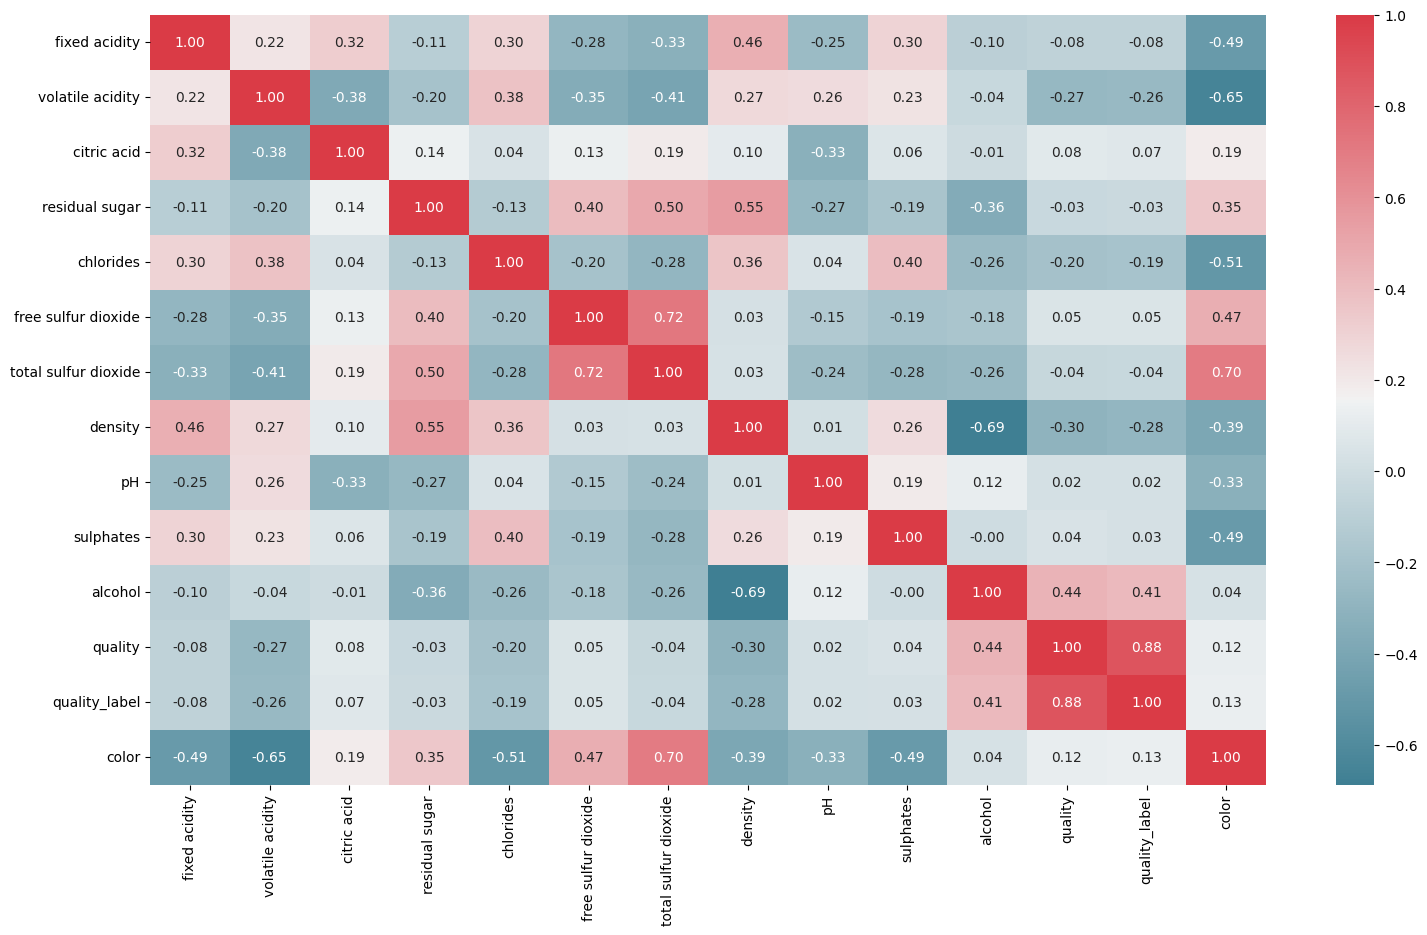

In [20]:
corr = df.iloc[:,1:].corr()
plt.figure(figsize=(18, 10))
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f")

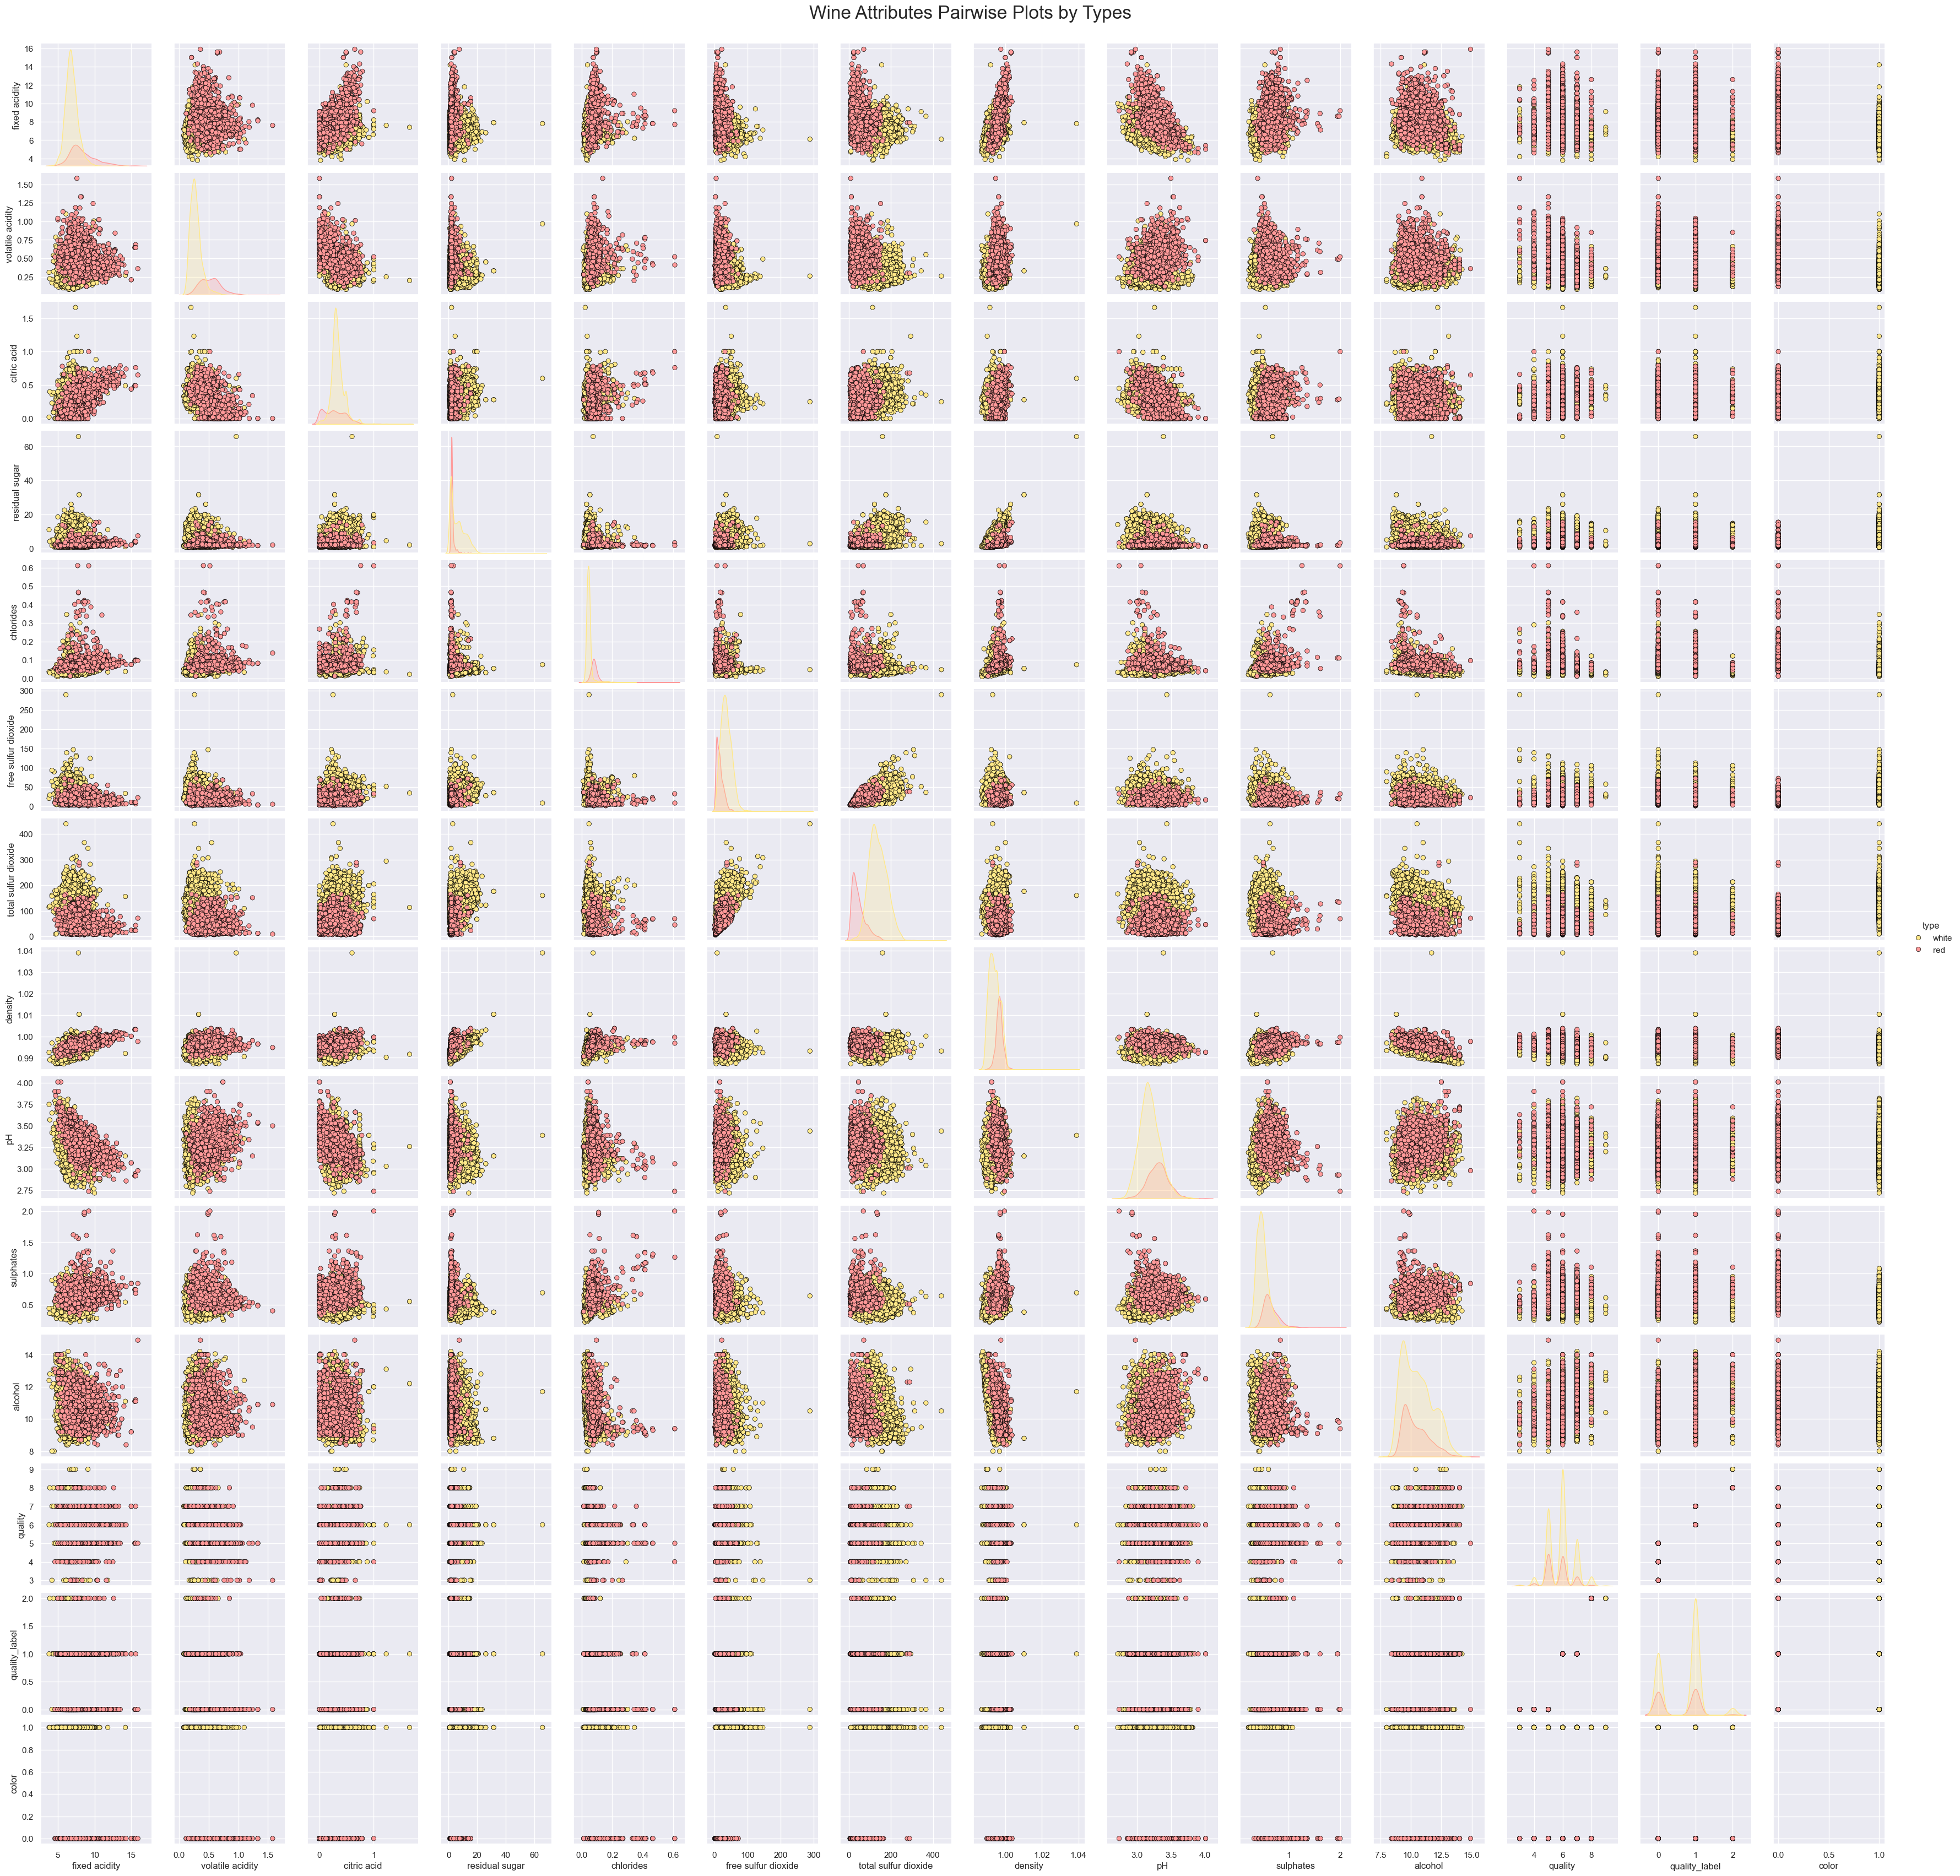

In [21]:
sns.set(font_scale=1.0)
g = sns.pairplot(data = df, hue='type', palette={'red': '#FF9999', 'white': '#FFE888'},plot_kws=dict(edgecolor='black', linewidth=0.5))
fig = g.fig 
fig.subplots_adjust(top=0.96, wspace=0.2)
t = fig.suptitle('Wine Attributes Pairwise Plots by Types', fontsize=24)

### Wine Types vs Quality and Acidity

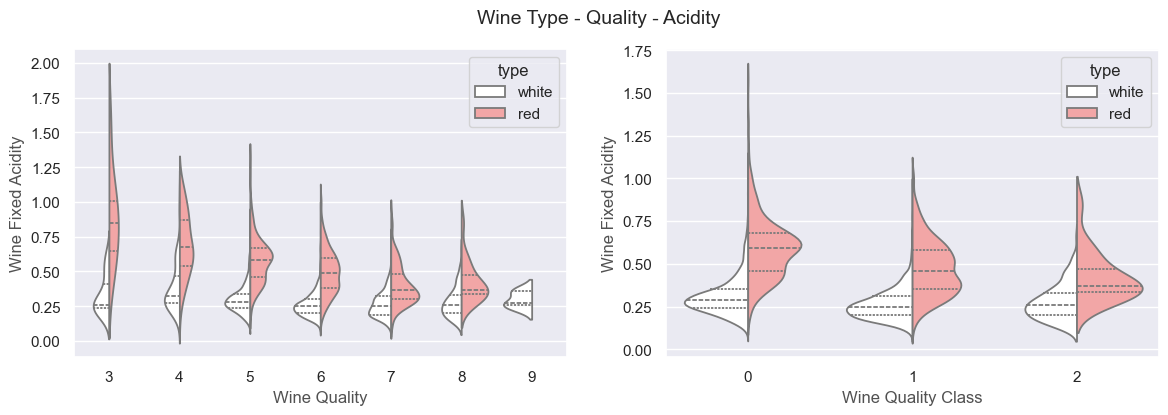

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
f.suptitle('Wine Type - Quality - Acidity', fontsize=14)

sns.violinplot(x='quality', y='volatile acidity', hue='type', data=df, split=True, inner='quart', linewidth=1.3,
               palette={'red': '#FF9999', 'white': 'white'}, ax=ax1)
ax1.set_xlabel("Wine Quality",size = 12,alpha=0.8)
ax1.set_ylabel("Wine Fixed Acidity",size = 12,alpha=0.8)

sns.violinplot(x='quality_label', y='volatile acidity', hue='type', data=df, split=True, inner='quart', linewidth=1.3,
               palette={'red': '#FF9999', 'white': 'white'}, ax=ax2)
ax2.set_xlabel("Wine Quality Class",size = 12,alpha=0.8)
ax2.set_ylabel("Wine Fixed Acidity",size = 12,alpha=0.8)
plt.show()

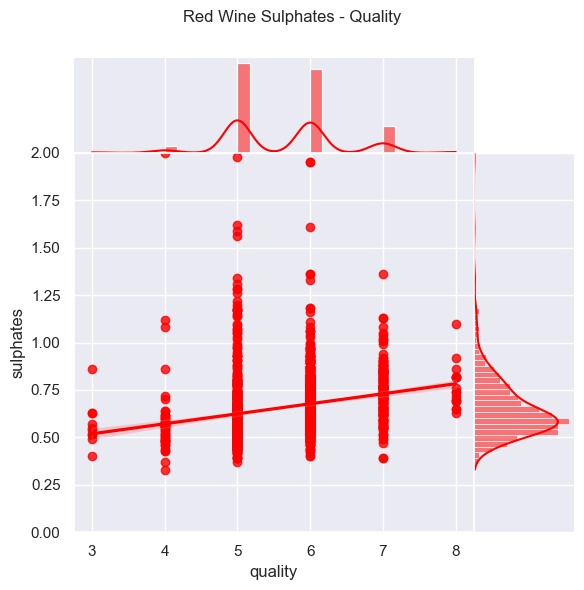

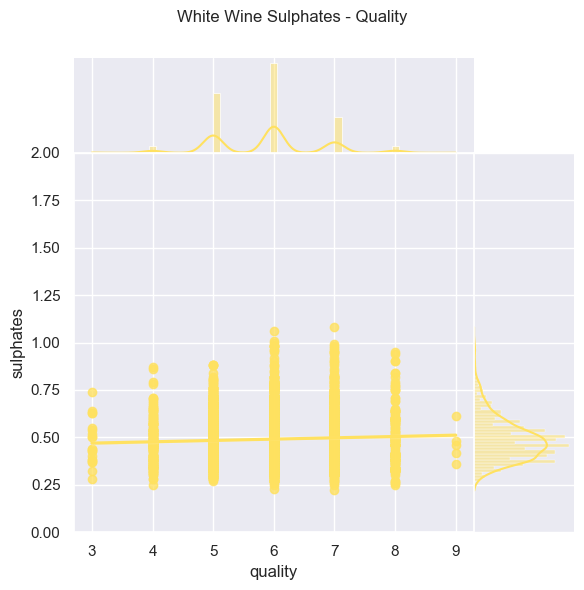

In [23]:
r = sns.jointplot(x='quality', y='sulphates', data=df[df.color == 0], # , ax = ax
                  kind='reg', ylim=(0, 2), color='red', space=0, ratio=4)
r.ax_joint.set_xticks(list(range(3,9)))
rfig = r.fig 
rfig.subplots_adjust(top=0.9)
t = rfig.suptitle('Red Wine Sulphates - Quality', fontsize=12)

w = sns.jointplot(x='quality', y='sulphates', data=df[df.color == 1],
                   kind='reg', ylim=(0, 2), color='#FFE160', space=0, ratio=4)
w.ax_joint.set_xticks(list(range(3,10)))
wfig = w.fig 
wfig.subplots_adjust(top=0.9)
t = wfig.suptitle('White Wine Sulphates - Quality', fontsize=12)

# BoxCox Transformation

<u>Box cox transformation of highly skewed features</u><br>
A Box Cox transformation is a way to transform non-normal data distribution into a normal shape.imageWhy does this matter?

Model bias and spurious interactions: <br>If you are performing a regression or any statistical modeling, this asymmetrical behavior may lead to a bias in the model. If a factor has a significant effect on the average, because the variability is much larger, many factors will seem to have a stronger effect when the mean is larger. This is not due, however, to a true factor effect but rather to an increased amount of variability that affects all factor effect estimates when the mean gets larger. This will probably generate spurious interactions due to a non-constant variation, resulting in a very complex model with many spurious and unrealistic interactions.
Normality is an important assumption for many statistical techniques: such as individuals control charts, Cp/Cpk analysis, t-tests and analysis of variance (ANOVA). A substantial departure from normality will bias your capability estimates.
One solution to this is to transform your data into normality using a Box-Cox transformation means that you are able to run a broader number of tests.

At the core of the Box Cox transformation is an exponent, lambda (λ), which varies from -5 to 5. All values of λ are considered and the optimal value for your data is selected; The 'optimal value' is the one which results in the best approximation of a normal distribution curve. The transformation of Y has the form:

At the core of the Box Cox transformation is an exponent, lambda (λ), which varies from -5 to 5. All values of λ are considered and the optimal value for your data is selected; The 'optimal value' is the one which results in the best approximation of a normal distribution curve.

(*)Note: the transformation for zero is log(0), otherwise all data would transform to Y**0 = 1. The transformation doesn't always work well, so make sure you check your data after the transformation with a normal probability plot or if the skew are reduced, tending to zero.

In [24]:
df.isnull().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
quality_label           0
color                   0
dtype: int64

In [25]:
numeric_features = list(df.dtypes[(df.dtypes != "str") & (df.dtypes !='object')].index)
numeric_features.remove('color')

skewed_features = df[numeric_features].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness = pd.DataFrame({'Skew' :skewed_features})   

# Get only higest skewed features
skewness = skewness[abs(skewness) > 0.7]
skewness = skewness.dropna()
skewness

Skew
chlorides            5.402178
sulphates            1.802523
fixed acidity        1.721248
volatile acidity     1.499692
residual sugar       1.436792
free sulfur dioxide  1.223143

In [26]:
l_opt = {}

for feature in skewness.index:
    df[feature], l_opt[feature] = boxcox(df[feature]+1)


skewed_features2 = df[skewness.index].apply(lambda x : skew(x.dropna())).sort_values(ascending=False)
skewness2 = pd.DataFrame({'New Skew' :skewed_features2})  

pd.concat([skewness, skewness2], axis=1)

Skew  New Skew
chlorides            5.402178  0.188541
sulphates            1.802523  0.010381
fixed acidity        1.721248 -0.062754
volatile acidity     1.499692  0.113617
residual sugar       1.436792  0.136151
free sulfur dioxide  1.223143 -0.036825

# Plot QQ Plot

In [27]:
def QQ_plot(data, measure):
    fig = plt.figure(figsize=(12,4))
    (mu, sigma) = norm.fit(data)
    fig1 = fig.add_subplot(121)
    sns.distplot(data, fit=norm)

    # Kde plot
    fig1.set_title(measure + f'Distribution: ({mu}, {sigma})')
    fig1.set_xlabel(measure)
    fig1.set_ylabel('Frequency')

    # QQ plot
    fig2 = fig.add_subplot(122)
    probplot(data, plot=fig2)
    fig2.set_title(measure + f"Probability plot: {data.skew(), data.kurt()}", loc='center')

    plt.tight_layout()
    plt.show()

C:\Users\vyassum\AppData\Local\Temp\ipykernel_78196\2833922754.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=norm)


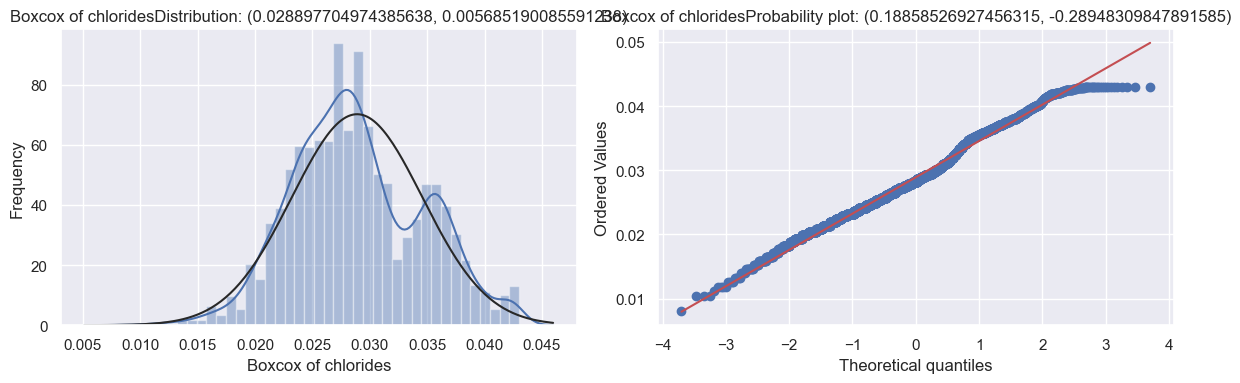

C:\Users\vyassum\AppData\Local\Temp\ipykernel_78196\2833922754.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=norm)


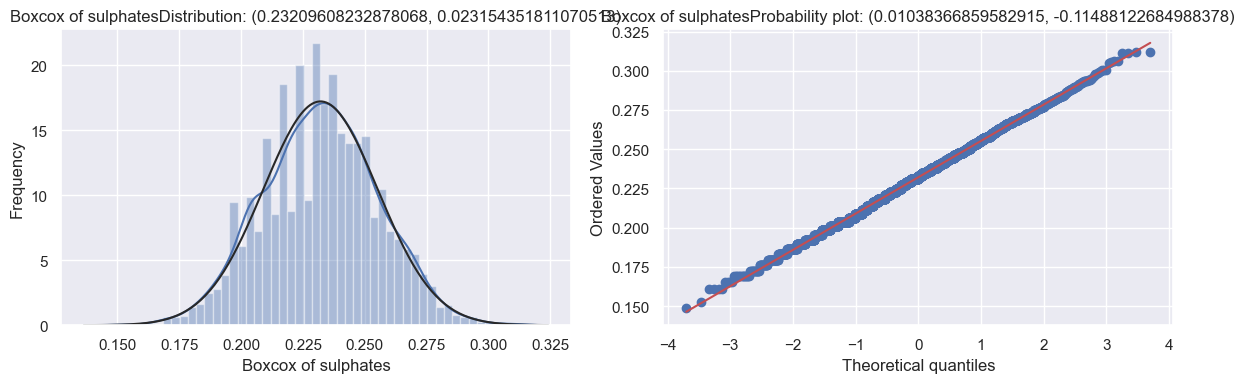

C:\Users\vyassum\AppData\Local\Temp\ipykernel_78196\2833922754.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=norm)


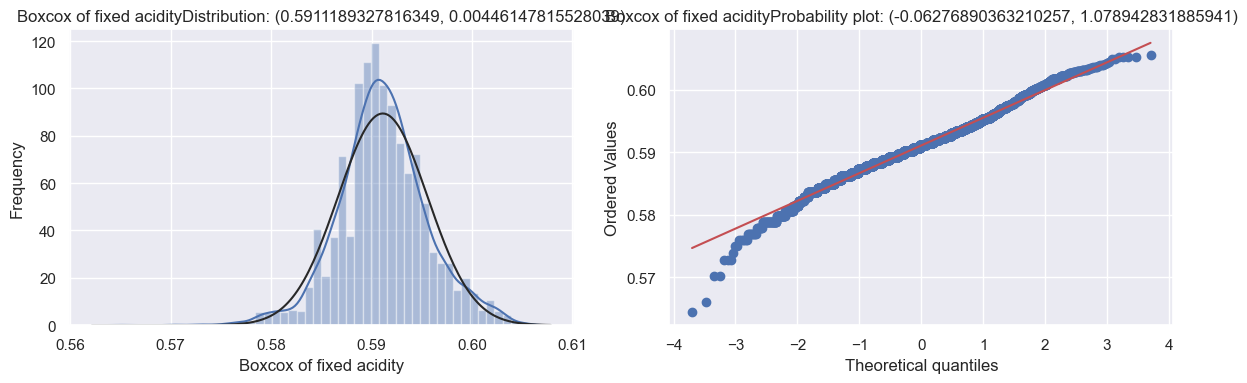

C:\Users\vyassum\AppData\Local\Temp\ipykernel_78196\2833922754.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=norm)


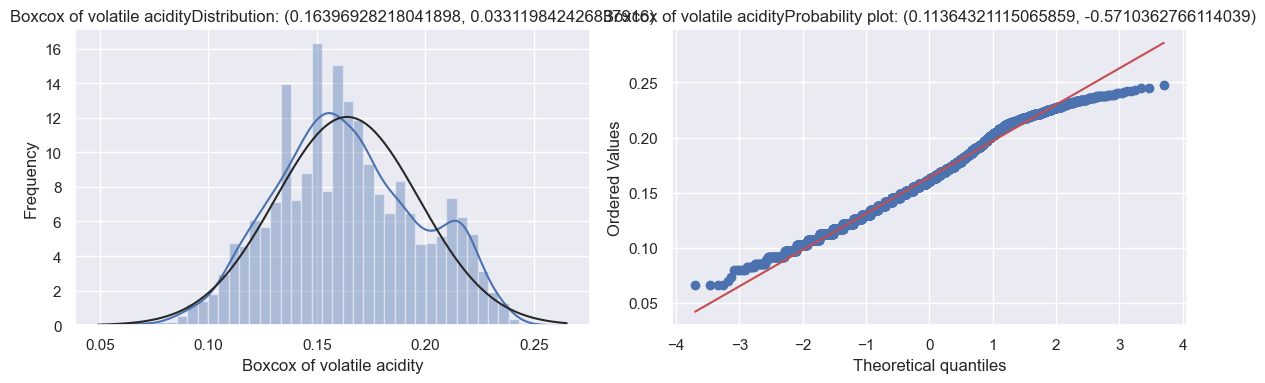

C:\Users\vyassum\AppData\Local\Temp\ipykernel_78196\2833922754.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=norm)


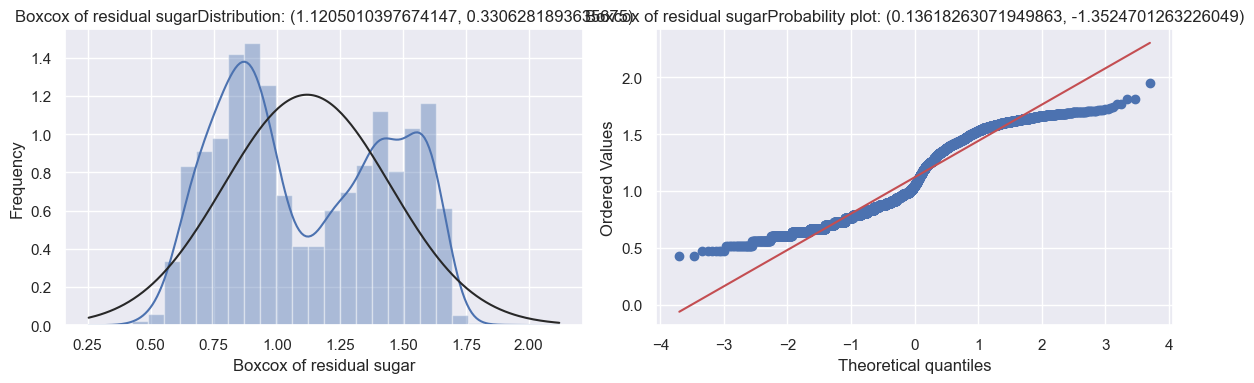

C:\Users\vyassum\AppData\Local\Temp\ipykernel_78196\2833922754.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data, fit=norm)


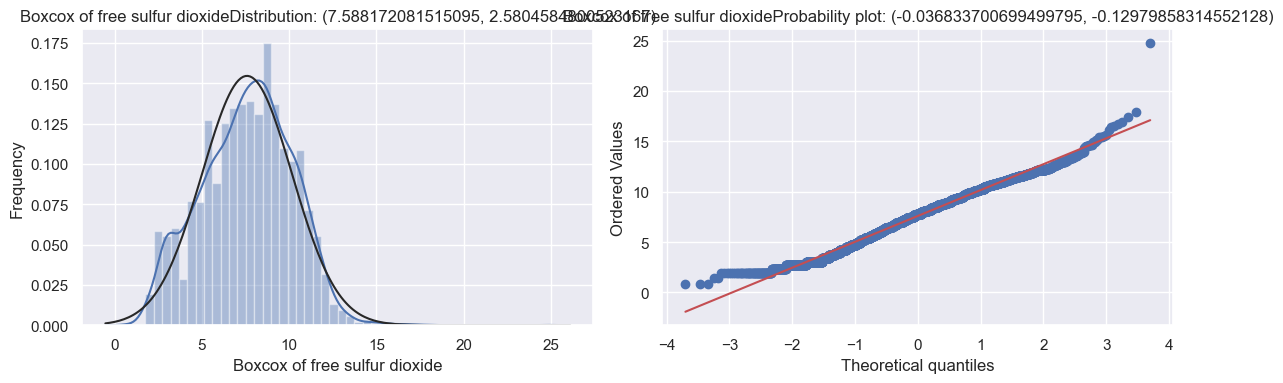

In [28]:
for feat in skewness.index:
    QQ_plot(df[feat], f'Boxcox of {feat}')

# Train Test Split

### Reshuffle Records

In [29]:
# re-shuffle records just to randomize data points
df = df.sample(frac=1, random_state=101).reset_index(drop=True)

class_tp = LabelEncoder()
y_tp = class_tp.fit_transform(df.type.values) # 1 - White; 0 - Red
df['color'] = y_tp

class_ql = {'low':0, 'medium': 1, 'high': 2}
y_ql = df.quality_label.map(class_ql)

In [30]:
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler, PolynomialFeatures, MinMaxScaler

In [31]:
cols = df.columns
cols = list(cols.drop(['type', 'quality_label', 'color']))
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, cols], y_tp, test_size=0.20, random_state=101, stratify=y_tp)

In [32]:
X_train.shape, X_test.shape

((5170, 12), (1293, 12))

In [33]:
from collections import Counter
from sklearn.metrics import f1_score
Counter(y_train)

Counter({1: 3896, 0: 1274})

# Learning Curve (varying training sizes)

In [34]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier


def get_models():
    dt = DecisionTreeClassifier()
    lin_svc = LinearSVC()
    non_lin_svc = SVC(kernel='rbf')
    knn = KNeighborsClassifier()
    mlp = MLPClassifier()
    adab = AdaBoostClassifier()

    models = [dt, lin_svc, non_lin_svc, knn, mlp, adab]
    return models

In [156]:
def calculate_perf(y_pred_train, y_pred_test, y_train, y_test):   
    f1_train = f1_score(y_pred_train, y_train)
    f1_test = f1_score(y_pred_test, y_test)
    return f1_train, f1_test
    

def plot_learning_curve(x, f1_scores_train, f1_scores_test, model, exp_type, metric_type = f1_score.__name__):
    model_name = type(model).__name__

    plt.figure(figsize=(8,4))
    plt.plot(x, f1_scores_train, label=f"{metric_type}-train", marker="o")
    plt.plot(x, f1_scores_test, label=f'{metric_type}-test', marker="o")
    plt.legend()
    title = f"{model_name}-lr-curve-{exp_type}"
    plt.title(title)
    plt.savefig(title+'png')
    

In [260]:
lr = LogisticRegression()
type(lr).__name__

'LogisticRegression'

DecisionTreeClassifier()
LinearSVC()
SVC()
KNeighborsClassifier()
MLPClassifier()
AdaBoostClassifier()


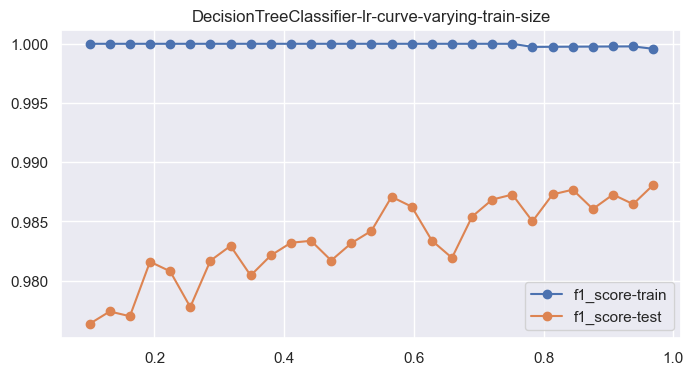

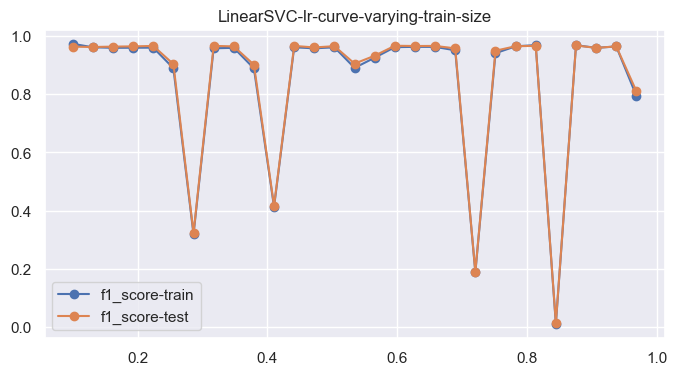

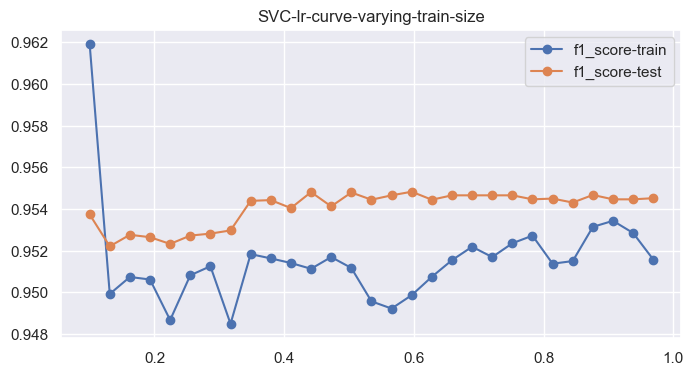

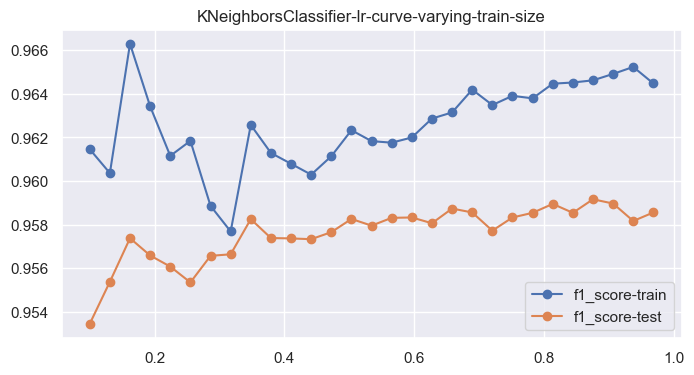

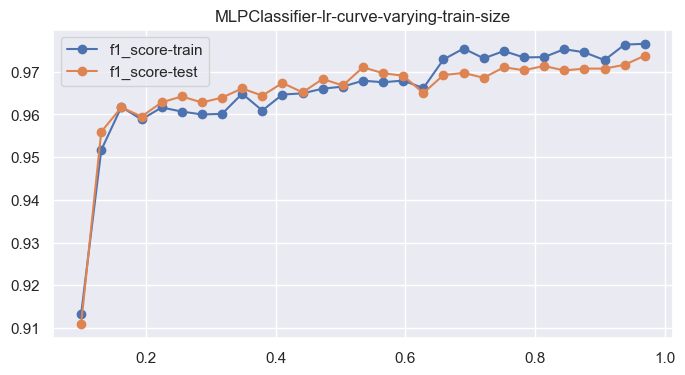

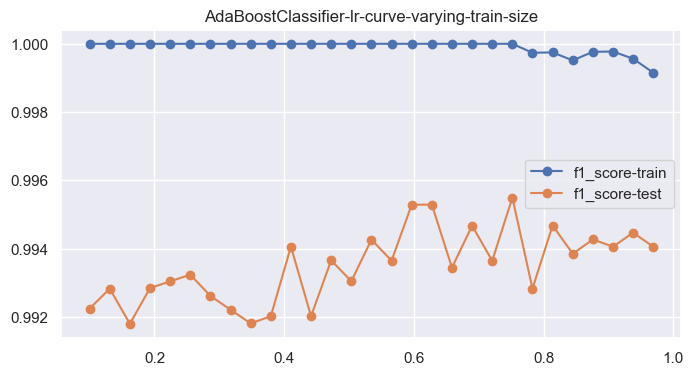

In [262]:
train_sizes = np.linspace(0.1,1,30)
exp_type="varying-train-size"
model_train_times = {}
model_prediction_times = {}
for m in get_models():
    model_name = type(m).__name__
    model_train_times[model_name] = []
    model_prediction_times[model_name] = []


for each_model in get_models():
    model_name = type(each_model).__name__
    print (each_model)
    f1_scores_train = []
    f1_scores_test = []

    
    for j,sample_proportion in enumerate(train_sizes):        
        if sample_proportion!=1:
            # Split Dataset
            X_train_subset, _, y_train_subset, _ = train_test_split(X_train, y_train, train_size=sample_proportion, random_state=101, stratify=y_train)    

            
            # Fit and measure time

            if j==28: # Max Training Time as training data is highest
                train_start_time = time.time()
                each_model.fit(X_train_subset, y_train_subset)
                train_time = time.time() - train_start_time
                model_train_times[model_name].append(train_time)
            else:
                each_model.fit(X_train_subset, y_train_subset)

            # Get Predictions
            y_pred_train = each_model.predict(X_train_subset)


            if j==1: # Max inference time as test set is highest here
                test_start_time = time.time()
                y_pred_test = each_model.predict(X_test)
                test_time = time.time() - test_start_time
                model_prediction_times[model_name].append(test_time)
            else:
                y_pred_test = each_model.predict(X_test)

            # Measure Performance
            f1_train_sample, f1_test_sample = calculate_perf(y_pred_train, y_pred_test, y_train_subset, y_test)
            f1_scores_train.append(f1_train_sample)
            f1_scores_test.append(f1_test_sample)
            

    # Plot performance of each model
    plot_learning_curve(train_sizes[:-1], f1_scores_train, f1_scores_test, each_model, exp_type)
    
        

# Measuring Train and Inference Times

In [264]:
pd.DataFrame(model_train_times)

DecisionTreeClassifier  LinearSVC       SVC  KNeighborsClassifier  \
0                0.014001   0.061001  0.052997              0.005998   

   MLPClassifier  AdaBoostClassifier  
0       2.395048            0.150002

In [265]:
pd.DataFrame(model_prediction_times)

DecisionTreeClassifier  LinearSVC    SVC  KNeighborsClassifier  \
0                   0.001      0.001  0.019                 0.069   

   MLPClassifier  AdaBoostClassifier  
0          0.002               0.016

# Fix Train-Test for next experiments

In [127]:
#X_train, X_test, y_train, y_test 
split_data = train_test_split(df.loc[:, cols], y_tp, test_size=0.50, random_state=101, stratify=y_tp)

# Learning Curve (as per iterations)
- NN
- Adaboost


In [231]:
rand_state = 101

def experiment_model(model, plot_x_param, exp_type, exp_param_name, exp_param_range, data, more_params = {}):

    data = (X_train, X_test, y_train, y_test)
    f1_scores_train = []
    f1_scores_test = []
    for each_param_value in exp_param_range:
        param_dict = {exp_param_name: each_param_value}
        if len(more_params):
            param_dict.update(more_params)
        
        if type(m).__name__ == 'KNeighborsClassifier':
            clf = model(**param_dict)
        else:
            param_dict.update({"random_state":rand_state})
            clf = model(**param_dict)
        clf.fit(X_train, y_train)

        # Get Predictions
        y_pred_train = clf.predict(X_train)
        y_pred_test = clf.predict(X_test)
    
        f1_train_sample, f1_test_sample = calculate_perf(y_pred_train, y_pred_test, y_train, y_test)
        f1_scores_train.append(f1_train_sample)
        f1_scores_test.append(f1_test_sample)
        
    plot_learning_curve(plot_x_param, f1_scores_train, f1_scores_test, clf, exp_type)

In [226]:
m = KNeighborsClassifier()
type(m).__name__

'KNeighborsClassifier'

### 1. Adaboost

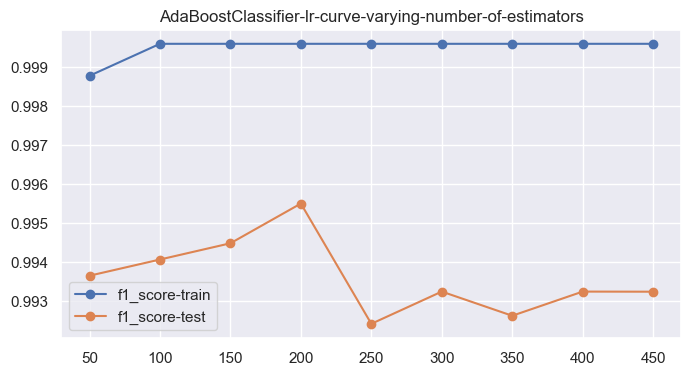

In [232]:
n_estimators_range = range(50, 500, 50)
model = AdaBoostClassifier
exp_type="varying-number-of-estimators"
title = type(model).__name__+ "with {}"

experiment_model(model, 
                 plot_x_param=n_estimators_range, 
                 exp_type=exp_type, 
                 exp_param_name="n_estimators", 
                 exp_param_range=n_estimators_range, 
                 data=split_data)

### 2. Neural Network

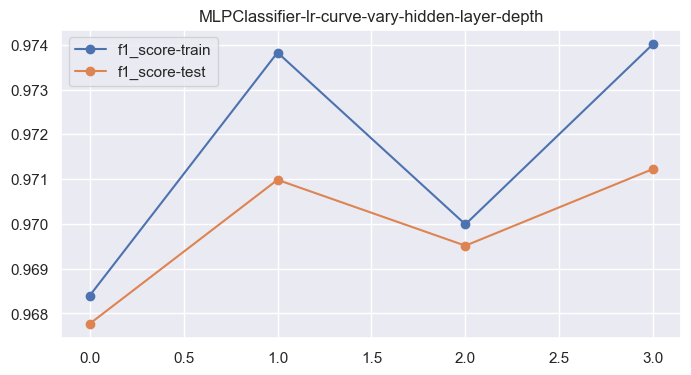

In [233]:
# Iterations Params
layer_size = 32
hidden_layers = ((layer_size), (layer_size, layer_size), (layer_size, layer_size, layer_size), (layer_size, layer_size, layer_size, layer_size))
model = MLPClassifier
exp_type="vary-hidden-layer-depth"
title = type(model).__name__+ "with {}"

experiment_model(model, 
                 plot_x_param=[i for i,h in enumerate(hidden_layers)], 
                 exp_type=exp_type, 
                 exp_param_name="hidden_layer_sizes", 
                 exp_param_range=hidden_layers, 
                 data=split_data)

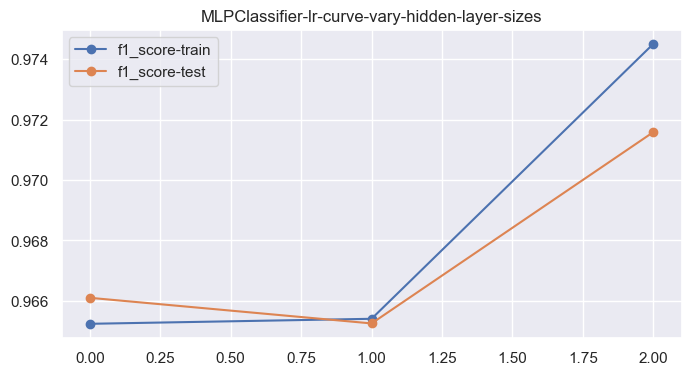

In [234]:
layer_size = 32
hidden_layers = hidden_layers = [(8,8), (16,16), (32,32)]
model = MLPClassifier
exp_type="vary-hidden-layer-sizes"
title = type(model).__name__+ "with {}"

experiment_model(model, 
                 plot_x_param=[i for i,h in enumerate(hidden_layers)], 
                 exp_type=exp_type, 
                 exp_param_name="hidden_layer_sizes", 
                 exp_param_range=hidden_layers, 
                 data=split_data)

### 3. Linear SVC

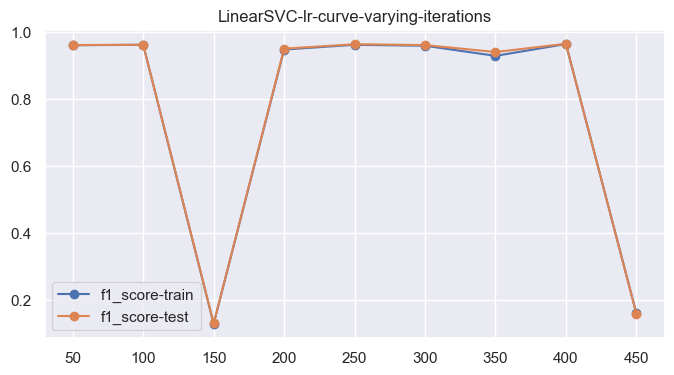

In [235]:
iterations = range(50, 500, 50)
model = LinearSVC
exp_type="varying-iterations"
title = type(model).__name__+ "with {}"

experiment_model(model, 
                 plot_x_param=iterations, 
                 exp_type=exp_type, 
                 exp_param_name="max_iter", 
                 exp_param_range=iterations, 
                 data=split_data)

### 4. SVC

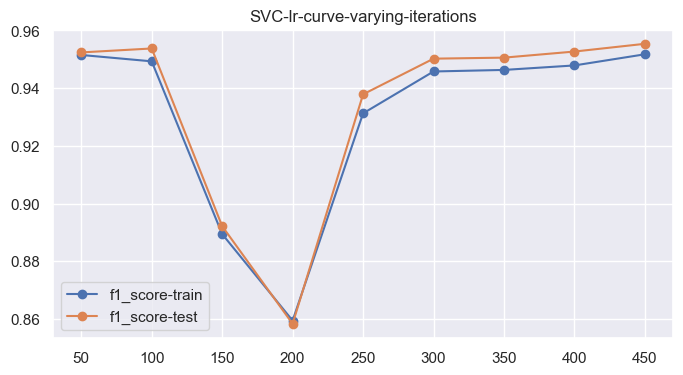

In [236]:
iterations = range(50, 500, 50)
model = SVC
exp_type="varying-iterations"
title = type(model).__name__+ "with {}"

experiment_model(model, 
                 plot_x_param=iterations, 
                 exp_type=exp_type, 
                 exp_param_name="max_iter", 
                 exp_param_range=iterations, 
                 data=split_data)

# Training and Testing error rates as a function of selected hyperparameter ranges

In [237]:
dt = DecisionTreeClassifier() # max_depth, max_features, max_leaf_nodes, class_weight
lin_svc = LinearSVC() # class_weight, max_iter
non_lin_svc = SVC(kernel='rbf') # class_weight
knn = KNeighborsClassifier() # n_neighbors, weights, leaf_size
mlp = MLPClassifier() # -> activation, momentum
adab = AdaBoostClassifier() # estimator

### 1. Decision Trees
- Parameters to experiment: max_depth, max_features, max_leaf_nodes, class_weight

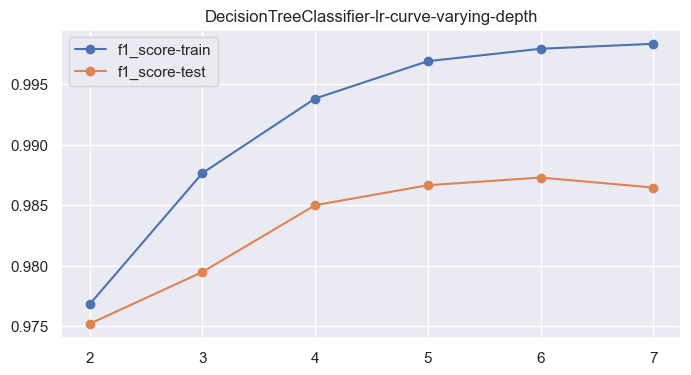

In [238]:
max_depth_range = range(2, 8)
model = DecisionTreeClassifier
exp_type="varying-depth"
title = type(model).__name__+ "with {}"

experiment_model(model, 
                 plot_x_param=max_depth_range, 
                 exp_type=exp_type, 
                 exp_param_name="max_depth", 
                 exp_param_range=max_depth_range, 
                 data=split_data)

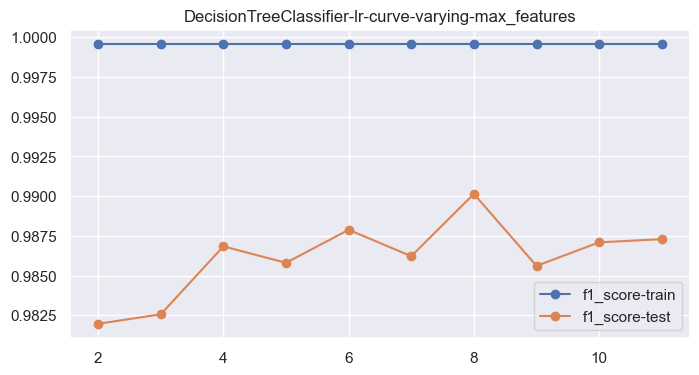

In [239]:
max_features = range(2, 12)
model = DecisionTreeClassifier
exp_type="varying-max_features"
title = type(model).__name__+ "with {}"

experiment_model(model, 
                 plot_x_param=max_features, 
                 exp_type=exp_type, 
                 exp_param_name="max_features", 
                 exp_param_range=max_features, 
                 data=split_data)

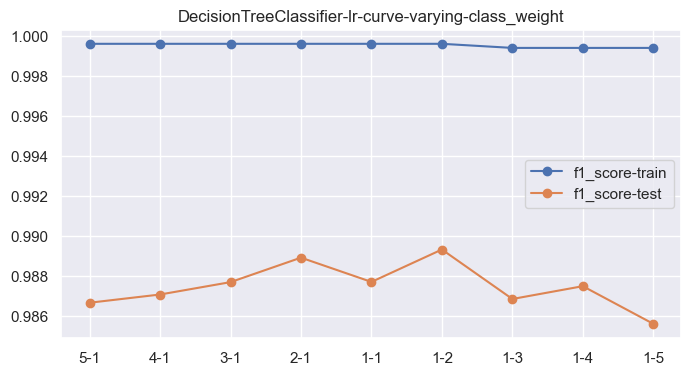

In [240]:
class_weight = [{0:5, 1:1}, {0:4, 1:1}, {0:3, 1:1},{0:2, 1:1}, {0:1, 1:1},{0:1, 1:2}, {0:1, 1:3},{0:1, 1:4}, {0:1, 1:5}]
model = DecisionTreeClassifier
exp_type="varying-class_weight"
title = type(model).__name__+ "with {}"

experiment_model(model, 
                 plot_x_param=[f"{d[0]}-{d[1]}" for d in class_weight], 
                 exp_type=exp_type, 
                 exp_param_name="class_weight", 
                 exp_param_range=class_weight, 
                 data=split_data)

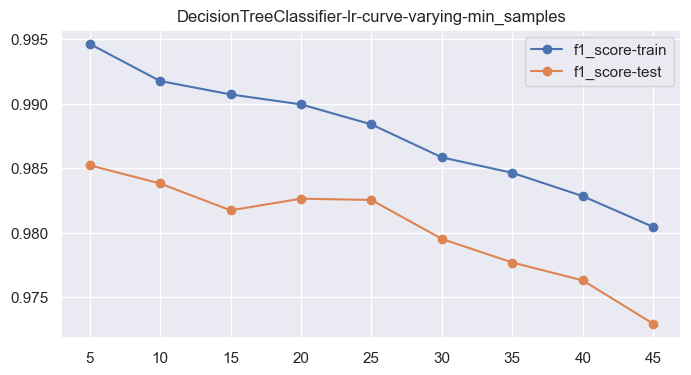

In [241]:
min_samples_leaf_range = range(5,50,5)

model = DecisionTreeClassifier
exp_type="varying-min_samples"
title = type(model).__name__+ "with {}"

experiment_model(model, 
                 plot_x_param=min_samples_leaf_range, 
                 exp_type=exp_type, 
                 exp_param_name="min_samples_leaf", 
                 exp_param_range=min_samples_leaf_range, 
                 data=split_data)

### 2. Linear SVC

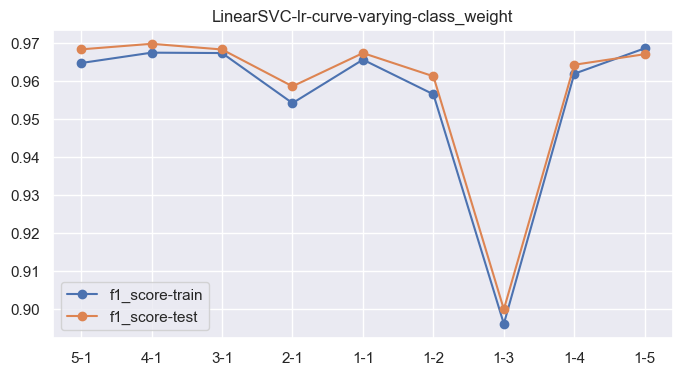

In [242]:
class_weight = [{0:5, 1:1}, {0:4, 1:1}, {0:3, 1:1},{0:2, 1:1}, {0:1, 1:1},{0:1, 1:2}, {0:1, 1:3},{0:1, 1:4}, {0:1, 1:5}]
model = LinearSVC
exp_type="varying-class_weight"
title = type(model).__name__+ "with {}"

experiment_model(model, 
                 plot_x_param=[f"{d[0]}-{d[1]}" for d in class_weight], 
                 exp_type=exp_type, 
                 exp_param_name="class_weight", 
                 exp_param_range=class_weight, 
                 data=split_data)

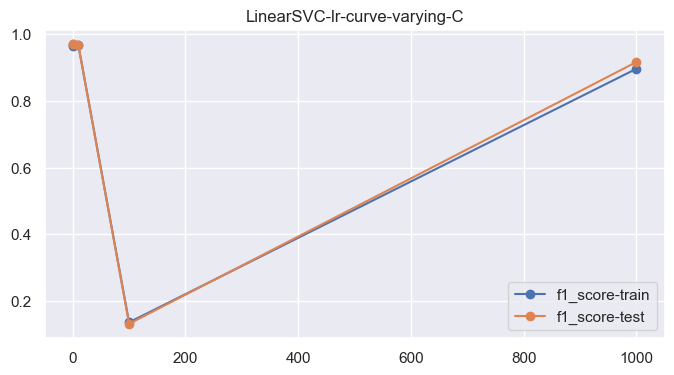

In [243]:
C_range= [0.1, 1, 10, 100, 1000]
model = LinearSVC
exp_type="varying-C"
title = type(model).__name__+ "with {}"

experiment_model(model, 
                 plot_x_param=C_range, 
                 exp_type=exp_type, 
                 exp_param_name="C", 
                 exp_param_range=C_range, 
                 data=split_data)

### 3. SVC

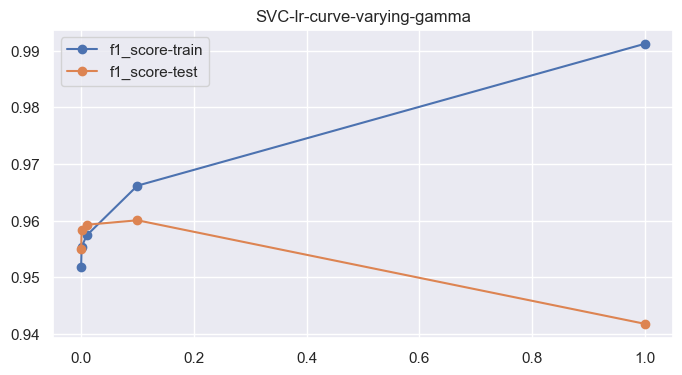

In [244]:
gamma_range = [1, 0.1, 0.01, 0.001, 0.0001]
model = SVC
exp_type="varying-gamma"
title = type(model).__name__+ "with {}"

experiment_model(model, 
                 plot_x_param=gamma_range, 
                 exp_type=exp_type, 
                 exp_param_name="gamma", 
                 exp_param_range=gamma_range, 
                 data=split_data)

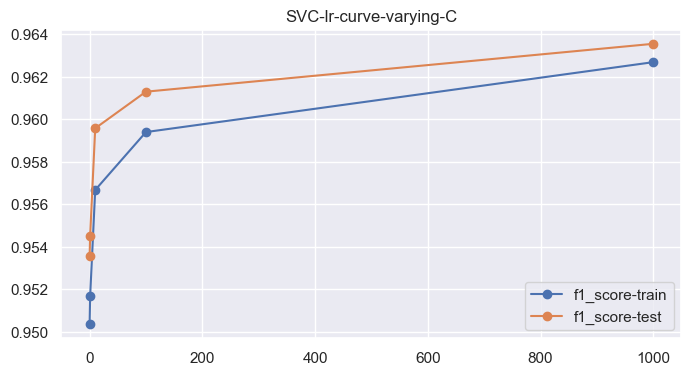

In [245]:
C_range= [0.1, 1, 10, 100, 1000]
model = SVC
exp_type="varying-C"
title = type(model).__name__+ "with {}"

experiment_model(model, 
                 plot_x_param=C_range, 
                 exp_type=exp_type, 
                 exp_param_name="C", 
                 exp_param_range=C_range, 
                 data=split_data)

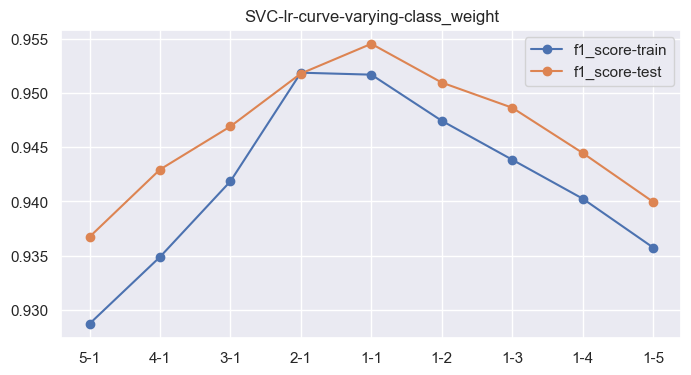

In [246]:
class_weight = [{0:5, 1:1}, {0:4, 1:1}, {0:3, 1:1},{0:2, 1:1}, {0:1, 1:1},{0:1, 1:2}, {0:1, 1:3},{0:1, 1:4}, {0:1, 1:5}]
model = SVC
exp_type="varying-class_weight"
title = type(model).__name__+ "with {}"

experiment_model(model, 
                 plot_x_param=[f"{d[0]}-{d[1]}" for d in class_weight], 
                 exp_type=exp_type, 
                 exp_param_name="class_weight", 
                 exp_param_range=class_weight, 
                 data=split_data)

### 4. K-Nearest-Neighbors

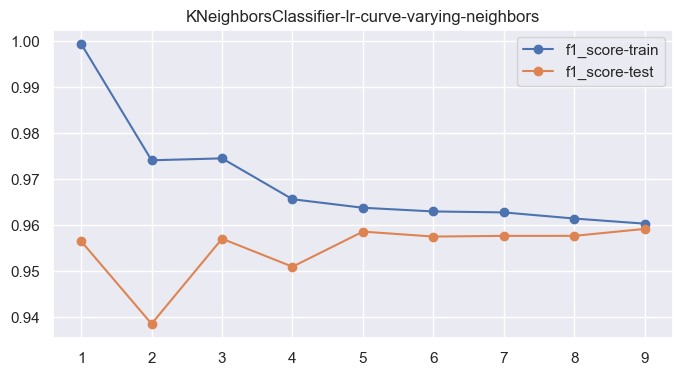

In [247]:
n_neighbors_range = range(1, 10)
model = KNeighborsClassifier
exp_type="varying-neighbors"
title = type(model).__name__+ "with {}"

experiment_model(model, 
                 plot_x_param=n_neighbors_range, 
                 exp_type=exp_type, 
                 exp_param_name="n_neighbors", 
                 exp_param_range=n_neighbors_range, 
                 data=split_data)


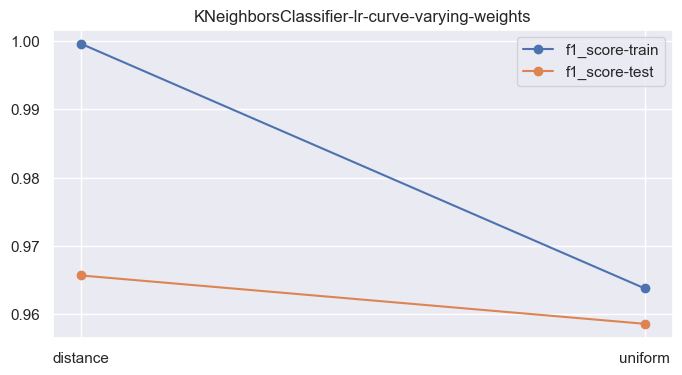

In [248]:
weights = ['distance','uniform']

model = KNeighborsClassifier
exp_type="varying-weights"
title = type(model).__name__+ "with {}"

experiment_model(model, 
                 plot_x_param=weights, 
                 exp_type=exp_type, 
                 exp_param_name="weights", 
                 exp_param_range=weights, 
                 data=split_data)

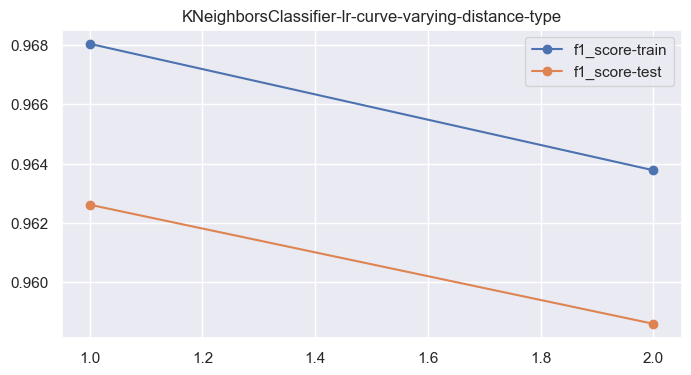

In [249]:
p = [1,2]
model = KNeighborsClassifier
exp_type="varying-distance-type"
title = type(model).__name__+ "with {}"

experiment_model(model, 
                 plot_x_param=p , 
                 exp_type=exp_type, 
                 exp_param_name="p", 
                 exp_param_range=p, 
                 data=split_data)

### 5. MLPClassifier()
-> activation, momentum

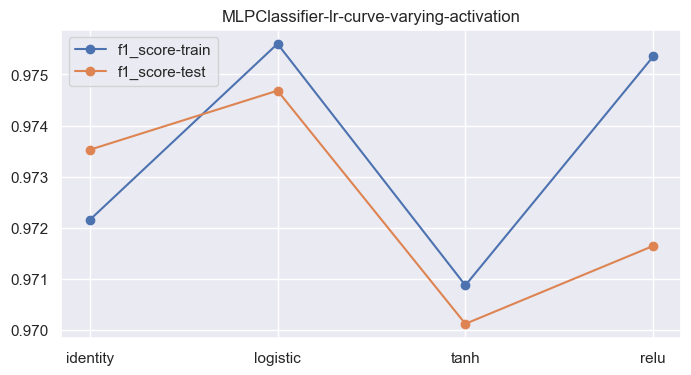

In [250]:
activation = ['identity', 'logistic', 'tanh', 'relu']
model = MLPClassifier
exp_type="varying-activation"
title = type(model).__name__+ "with {}"

experiment_model(model, 
                 plot_x_param=activation, 
                 exp_type=exp_type, 
                 exp_param_name="activation", 
                 exp_param_range=activation, 
                 data=split_data)

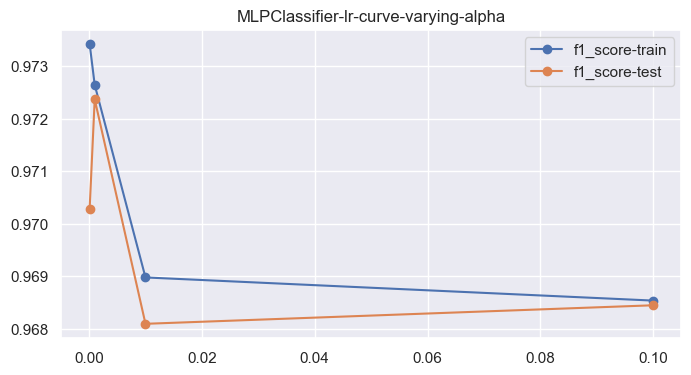

In [251]:
alpha = [0.0001, 0.001, 0.01, 0.1]
model = MLPClassifier
exp_type="varying-alpha"
title = type(model).__name__+ "with {}"

experiment_model(model, 
                 plot_x_param=alpha, 
                 exp_type=exp_type, 
                 exp_param_name="alpha", 
                 exp_param_range=alpha, 
                 data=split_data)

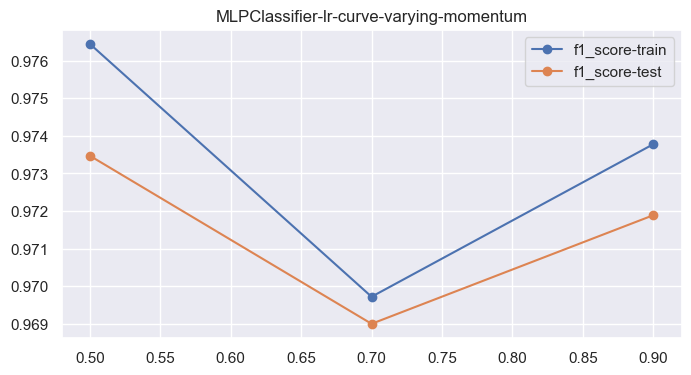

In [252]:
momentum = [0.9, 0.7, 0.5]
model = MLPClassifier
exp_type="varying-momentum"
title = type(model).__name__+ "with {}"

experiment_model(model, 
                 plot_x_param=momentum, 
                 exp_type=exp_type, 
                 exp_param_name="momentum", 
                 exp_param_range=momentum, 
                 data=split_data)

### 6. AdaBoostClassifier 

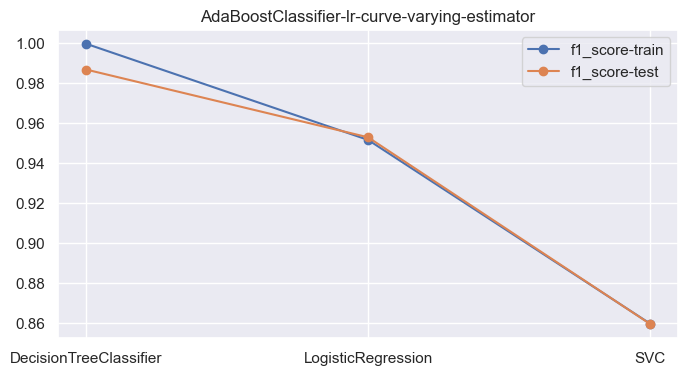

In [253]:
estimator = [DecisionTreeClassifier(), LogisticRegression(), SVC()]
model = AdaBoostClassifier
exp_type="varying-estimator"
title = type(model).__name__+ "with {}"

kwargs = {'algorithm':'SAMME'}
experiment_model(model, 
                 plot_x_param=[type(e).__name__ for e in estimator], 
                 exp_type=exp_type, 
                 exp_param_name="estimator", 
                 exp_param_range=estimator,
                 more_params = kwargs,
                 data=split_data)

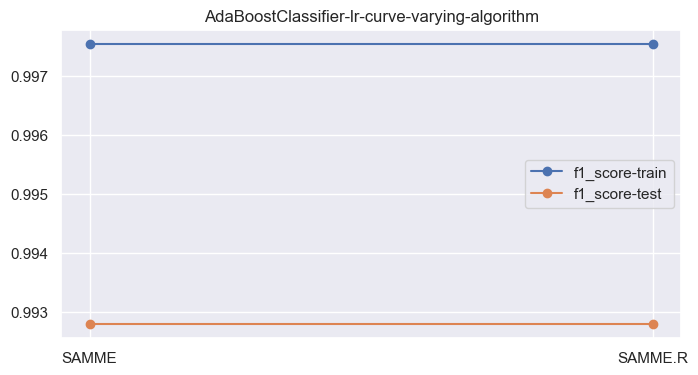

In [254]:
algorithm = ['SAMME', 'SAMME.R']

model = AdaBoostClassifier
exp_type="varying-algorithm"
title = type(model).__name__+ "with {}"

kwargs = {'algorithm':'SAMME'}
experiment_model(model, 
                 plot_x_param=algorithm, 
                 exp_type=exp_type, 
                 exp_param_name="algorithm", 
                 exp_param_range=algorithm,
                 more_params = kwargs,
                 data=split_data)

# Analyses of your results. 

- Why did you get the results you did? Compare and contrast the different algorithms.
- What sort of changes might you make to each of those algorithms to improve performance?- 
How fast were they in terms of wall clock time? Iterations
-  Would cross-validation help?
-  How much performance was due to the problems you chose? 
-   Which algorithm performed best? How do you define 
best?

In [ ]:
# Measuring wall-clock time - completed

In [270]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import RobustScaler

In [ ]:
# Finding Optimal Models, also with cross validation and grid search

In [ ]:
dt = DecisionTreeClassifier() # max_depth, max_features, max_leaf_nodes, class_weight
lin_svc = LinearSVC() # class_weight, max_iter
non_lin_svc = SVC(kernel='rbf') # class_weight
knn = KNeighborsClassifier() # n_neighbors, weights, leaf_size
mlp = MLPClassifier() # -> activation, momentum
adab = AdaBoostClassifier() # estimator

In [287]:
param_grid_dt = {
    "estimator__max_depth" : range(2, 8),
    "estimator__max_features" : range(2, 12),
    "estimator__class_weight" : [{0:5, 1:1}, {0:4, 1:1}, {0:3, 1:1},{0:2, 1:1}, {0:1, 1:1},{0:1, 1:2}, {0:1, 1:3},{0:1, 1:4}, {0:1, 1:5}],
    "estimator__min_samples_leaf" : range(5,50,5)}

param_grid_lin_svc = {
    "estimator__class_weight" : [{0:5, 1:1}, {0:4, 1:1}, {0:3, 1:1},{0:2, 1:1}, {0:1, 1:1},{0:1, 1:2}, {0:1, 1:3},{0:1, 1:4}, {0:1, 1:5}],
    "estimator__C": [0.1, 1, 10, 100, 1000]}

param_grid_svc = {
    'estimator__C': [0.1, 1, 10, 100, 1000],  
    'estimator__gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
    'estimator__kernel': ['rbf', 'tanh']} 

param_grid_knn = {
    "estimator__n_neighbors" : range(1, 10),
    "estimator__weights" : ['distance','uniform'],
    "estimator__p" : [1,2]}

param_grid_mlp = {
    "estimator__activation" : ['identity', 'logistic', 'tanh', 'relu'],
    "estimator__alpha" : [0.0001, 0.001, 0.01, 0.1],
    "estimator__momentum" : [0.9, 0.7, 0.5]}

param_grid_ada = {
    "estimator__estimator" : [DecisionTreeClassifier(), LogisticRegression(), SVC()]}

In [281]:
def get_pipeline(model_class):
    scaler = RobustScaler()
    estimator = model_class()

    pipeline_steps = [('scaler', scaler), ('estimator', estimator)]
    pipeline_steps = Pipeline(steps=pipeline_steps)
    return pipeline_steps

# Finding Best Model

In [284]:
grid = GridSearchCV(get_pipeline(DecisionTreeClassifier),
                    param_grid_dt,
                    refit = True,
                    verbose = 3,
                    scoring='f1',
                    n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_score_

Fitting 5 folds for each of 4860 candidates, totalling 24300 fits


0.989729174564653

In [288]:
grid = GridSearchCV(get_pipeline(LinearSVC),
                    param_grid_lin_svc,
                    refit = True,
                    verbose = 3,
                    scoring='f1',
                    n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_score_

Fitting 5 folds for each of 45 candidates, totalling 225 fits


0.9956804739346472

In [295]:
grid = GridSearchCV(get_pipeline(SVC),
                    param_grid_svc,
                    refit = True,
                    verbose = 3,
                    scoring='f1',
                    n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_score_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


0.9973333324702025

In [291]:
grid = GridSearchCV(get_pipeline(KNeighborsClassifier),
                    param_grid_knn,
                    refit = True,
                    verbose = 3,
                    scoring='f1',
                    n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_score_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


0.9963017797819491

In [293]:
grid = GridSearchCV(get_pipeline(MLPClassifier),
                    param_grid_mlp,
                    refit = True,
                    verbose = 3,
                    scoring='f1',
                    n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_score_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


0.9971303046977669

In [294]:
grid = GridSearchCV(get_pipeline(AdaBoostClassifier),
                    param_grid_ada,
                    refit = True,
                    verbose = 3,
                    scoring='f1',
                    n_jobs=-1)
grid.fit(X_train, y_train)
grid.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


0.9923891161469506